# Least Square Fitting with scipy.optimize
## Fitting an ellipse to an arc to demonstrate calibrating 2-axis magnetometer data

The following can be used for a magnetometer that has the z-axis in the vertical position and does not tilt.

Import dependencies:

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

First, make an arc with noise to test fitting.  The arc will have 100 data points and will cover 60% of a circle.  The center of the circle is determined by xc and yc, and the magnitudes of the major and minor axes are xm and ym.  We'll make random sized and shaped circles, along with random noise, and have the points stored in the arrays x and y. 

In [81]:
npts = 100
circ_fraction = .6
xrad = np.arange(npts)*2*np.pi*circ_fraction/(npts)

xc = np.random.normal(0,10)
yc = np.random.normal(0,10)
xm = np.random.normal(10,3)
ym = np.random.normal(10,3)
x_noise = np.random.normal(0,0.1,npts)
y_noise = np.random.normal(0,0.1,npts)

x = np.cos(xrad)*xm+xc+x_noise
y = np.sin(xrad)*ym+yc+y_noise

The goal will be to calcuate xc, yc, xm, and ym by fitting the arc.  Here we create the general function of an ellipse that will be used to fit the data.  

In [82]:
def calc_params(xc, yc, xm, ym):
    return (((x-xc)/xm)**2 + ((y-yc)/ym)**2)    
    
def lq_function(c):
    fit = calc_params(*c)
    return fit - 1

Get estimates for the parameters being fit.

In [83]:
x_cen = x.mean()
y_cen = y.mean()
x_mag = (x.max()-x.min())/2.
y_mag = (y.max()-y.min())/2.
params_estimate = x_cen, y_cen, x_mag, y_mag

Fit the data.  params_2 are the fit parameters, ier notes if the fit was successful (must be 1, 2, 3 or 4).  The general form for an ellipse is equal to 1, and we can see how well the fit was by finding the sum of the squares of the residuals.

In [84]:
params_2, ier = optimize.leastsq(lq_function, params_estimate)

if ier <= 4:
    print "Fit was successful.\n"
else:
    print "Fit was unsuccessful.\n"
    
xc_2, yc_2, xm_2, ym_2 = params_2
fit_2 = calc_params(*params_2)
residue_2 = sum((fit_2 - 1)**2)

Fit was successful.



Make an ellipse with the fit parameters with a full circle array to view the fit.

Real parameters:
[-12.3749512750431, 7.3797358256527765, 4.560836744110595, 7.235925981395058]

Calculated parameters:
[-12.36515457   7.31911958   4.56416304   7.32045888]


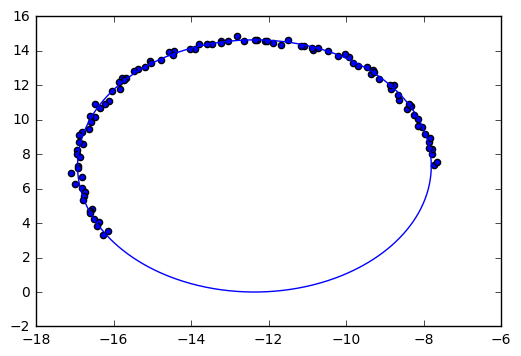

In [85]:
n2 = 1000
x2 = np.arange(n2)*2*np.pi/(n2)

xfit = np.cos(x2)*xm_2+xc_2
yfit = np.sin(x2)*ym_2+yc_2

print "Real parameters:"
print [xc,yc,xm,ym]
print "\nCalculated parameters:"
print params_2

plt.scatter(x, y)
plt.plot(xfit,yfit)
plt.show()


The parameters can be used to calibrate the magnetometer and make a unit circle.

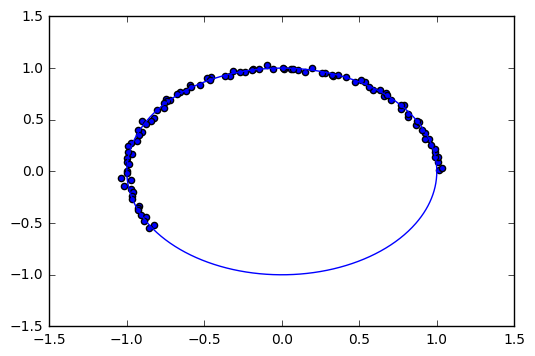

In [86]:
x_cal = (x-xc_2)/xm_2
y_cal = (y-yc_2)/ym_2

xunit = np.cos(x2)
yunit = np.sin(x2)

plt.scatter(x_cal, y_cal)
plt.plot(xunit,yunit)
plt.show()

The heading of the magnetometer can be found.  0deg is when the x-axis is pointed north, and the heading ranges from -180 to 180deg.

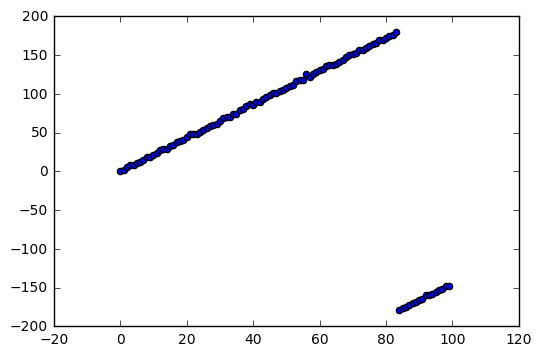

In [87]:
heading = np.arctan2(y_cal,x_cal) * 180 / np.pi

plt.scatter(np.arange(npts),heading)
plt.show()